In [1]:
from drosoph_vae.settings.config import SetupConfig
# adapt according to your machine (0 should be fine, if you have a GPU)
if SetupConfig.runs_on_lab_server():
    %env CUDA_DEVICE_ORDER=PCI_BUS_ID
    %env CUDA_VISIBLE_DEVICES=1

# VAE using the reparametrization trick

## Imports and enabling of eager execution

In [2]:
import json
from collections import namedtuple
from functools import partial
import itertools
from functional import seq
from functools import reduce
import warnings
import os
import traceback
import time
import glob
import matplotlib.pyplot as plt
from matplotlib import gridspec
import seaborn as sns
import numpy as np
import pandas as pd
import PIL
import imageio
from IPython import display
from pathlib import Path
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.manifold import TSNE
from sklearn.cluster import AgglomerativeClustering
from hdbscan import HDBSCAN

from importlib import reload # for debugging and developing, optional

import tensorflow as tf
import tensorflow.contrib as tfc
import tensorflow.contrib.eager as tfe
import tensorflow.keras as tfk
import tensorflow.keras.layers as tfkl
import tensorflow_probability as tfp

# for the KL-loss explosion problem
tf.enable_eager_execution()
# we currently handle them ourselves. but with this, it will throw an error before we can apply the fix
tfe.seterr(inf_or_nan='raise')

# otherwise TF will print soooo many warnings
warnings.filterwarnings('ignore', '.*FutureWarning.*np.complexfloating.*')

from drosoph_vae.helpers.tensorflow import _TF_DEFAULT_SESSION_CONFIG_
import drosoph_vae.helpers.tensorflow as tf_helpers
sess = tf.InteractiveSession(config=_TF_DEFAULT_SESSION_CONFIG_)
tf.keras.backend.set_session(sess)

from drosoph_vae import data_loading
from drosoph_vae import settings
from drosoph_vae import preprocessing
from drosoph_vae.helpers import video, plots, misc, jupyter
from drosoph_vae.helpers.misc import extract_args, chunks, foldl, if_last
from drosoph_vae.helpers.jupyter import display_video
from drosoph_vae.helpers.logging import enable_logging
from drosoph_vae.helpers.tensorflow import to_tf_data
from drosoph_vae.settings import config, skeleton
from drosoph_vae.settings import data as SD
from drosoph_vae.settings.config import RunConfig, SetupConfig
from drosoph_vae.training import vae as vae_training
from drosoph_vae.training import supervised as supervised_training
from drosoph_vae.losses.normalized_mutual_information import normalized_mutual_information
from drosoph_vae.losses.purity import purity
from drosoph_vae.models.drosoph_vae_conv import DrosophVAEConv
from drosoph_vae.models.drosoph_vae_skip_conv import DrosophVAESkipConv

In [3]:
jupyter.fix_layout()
enable_logging()

# Setup, loading of data

In [4]:
setup_cfg = SetupConfig()
run_cfg = RunConfig()

frame_data, frame_labels, normalisation_factors = data_loading.load_labelled_data(run_config=run_cfg, setup_config=setup_cfg)

2019-06-15 23:47:34,202 - root - WARNING - preprocessing - this works only for the first legs!
2019-06-15 23:47:34,208 - root - WARNING - preprocessing - this works only for the first legs!
2019-06-15 23:47:34,211 - root - WARNING - preprocessing - this works only for the first legs!
2019-06-15 23:47:34,214 - root - WARNING - preprocessing - this works only for the first legs!
2019-06-15 23:47:34,217 - root - WARNING - preprocessing - this works only for the first legs!
2019-06-15 23:47:34,221 - root - WARNING - preprocessing - this works only for the first legs!
2019-06-15 23:47:34,224 - root - WARNING - preprocessing - this works only for the first legs!
2019-06-15 23:47:34,228 - root - WARNING - preprocessing - this works only for the first legs!
2019-06-15 23:47:34,232 - root - WARNING - preprocessing - this works only for the first legs!
2019-06-15 23:47:34,235 - root - WARNING - preprocessing - this works only for the first legs!
2019-06-15 23:47:34,239 - root - WARNING - preproc

huh?? something odd with Experiment(study_id='180921_aDN_CsCh', fly_id='Fly6', experiment_id='003_SG1'): /home/sam/proj/epfl/neural_clustering_data/experiments/180921_aDN_CsCh/Fly6/003_SG1/behData/images: [Errno 2] No such file or directory: '/home/sam/proj/epfl/neural_clustering_data/experiments/180921_aDN_CsCh/Fly6/003_SG1/behData/images'
huh?? something odd with Experiment(study_id='180921_aDN_CsCh', fly_id='Fly3', experiment_id='001_SG1'): /home/sam/proj/epfl/neural_clustering_data/experiments/180921_aDN_CsCh/Fly3/001_SG1/behData/images: [Errno 2] No such file or directory: '/home/sam/proj/epfl/neural_clustering_data/experiments/180921_aDN_CsCh/Fly3/001_SG1/behData/images'
huh?? something odd with Experiment(study_id='180921_aDN_CsCh', fly_id='Fly4', experiment_id='003_SG1'): /home/sam/proj/epfl/neural_clustering_data/experiments/180921_aDN_CsCh/Fly4/003_SG1/behData/images: [Errno 2] No such file or directory: '/home/sam/proj/epfl/neural_clustering_data/experiments/180921_aDN_CsCh/

# preprocessing

In [5]:
def to_int_value(frame_with_label):
    return np.array([l.label.value for l in frame_with_label[:,1]])

In [6]:
if run_cfg['data_type'] == config.DataType.ANGLE_3D:
    frame_data, frame_labels, selected_columns, normalisation_factors = preprocessing.preprocess_angle_3d_data(
        frame_data, frame_labels, **run_cfg.preprocessing_parameters())
if run_cfg['data_type'] == config.DataType.POS_2D:
    selected_columns = None
    # preprocessing for the pos_2d data happens inside the loading function, yeah... I know ugly
    frame_data, frame_labels = preprocessing.preprocess_pos_2d_data(frame_data, frame_labels)

In [7]:
scaler = StandardScaler()

n_train_data_points = int(frame_data.shape[0] * run_cfg['train_test_ratio'])

X_train = scaler.fit_transform(frame_data[:n_train_data_points])
X_test = scaler.transform(frame_data[n_train_data_points:])
y_train = to_int_value(frame_labels[:n_train_data_points])
y_test = to_int_value(frame_labels[n_train_data_points:])
frame_labels_train = frame_labels[:n_train_data_points]
frame_labels_test = frame_labels[n_train_data_points:]

if run_cfg['use_time_series']:
    X_train, X_test, y_train, y_test, frame_labels_train, frame_labels_test = [misc.to_time_series_np(x, sequence_length=run_cfg['time_series_length']) 
                                        for x in (X_train, X_test, y_train, y_test, frame_labels_train, frame_labels_test)]

In [8]:
##
## debugging overwrite
##
#    
#if run_config['debug']:
#    if run_config['d_zero_data']:
#        # resetting the scaler to make our life easier down below the pipeline
#        _dummy_data_ = np.zeros_like(joint_positions)
#    elif run_config['d_sinoid_data']:
#        if run_config['data_type'] == _DATA_TYPE_2D_POS_:
#            _dummy_data_ = np.zeros_like(joint_positions)
#            for frame in range(_dummy_data_.shape[0]):
#                for joint in range(_dummy_data_.shape[1]):
#                    _dummy_data_[frame, joint, :] = np.sin(2 * np.pi * frame/_dummy_data_.shape[0] + joint / _dummy_data_.shape[1])
#                
#        else:
#            _dummy_data_ = np.array([[np.sin(x) + (offset / joint_positions.shape[1]) 
#                                      for x in range(len(joint_positions))] 
#                                     for offset in range(joint_positions.shape[1])]).T.astype(joint_positions.dtype)
#    elif run_config['d_sinoid_cluster_data']:
#        if run_config['data_type'] == _DATA_TYPE_2D_POS_:
#            raise NotImplementedError
#        else:
#            _dummy_data_ = np.zeros_like(joint_positions)
#            _dummy_labels_ = np.zeros(joint_positions.shape[0])
#            for c in range(_dummy_data_.shape[1]):
#                _dummy_data_[:, c], _dummy_labels_ = dummy_data_complex_sine_like(_dummy_data_.shape[0])
#            
#    if run_config['data_type'] == _DATA_TYPE_2D_POS_:
#        _dummy_data_ = misc.prep_2d_pos_data(_dummy_data_)
#        
#    if run_config['use_time_series']:
#        reshaped_joint_position = scaler.fit_transform(_dummy_data_)
#        reshaped_joint_position = misc.to_time_series_np(reshaped_joint_position, sequence_length=run_config['time_series_length'])
#        labels = _dummy_labels_[run_config['time_series_length'] - 1:]
#    else:
#        reshaped_joint_position = _dummy_data_
#        labels = _dummy_labels_

In [9]:
reload(plots)
#
# Making sure that the train/test distributions are not too different from each other
#
    
#if run_cfg['data_type'] == data_loading.DataType.ANGLE_3D:
#    fig = plots.plot_3d_angle_data_distribution(X_train[_plt_data_idx_],
#                                                X_test[_plt_data_idx_],
#                                                selected_columns, 
#                                                exp_desc=run_cfg.description())
#else:
#    fig = plots.plot_2d_distribution(data_train[_plt_data_idx_], data_test[_plt_data_idx_], exp_desc=run_config.description())

<module 'drosoph_vae.helpers.plots' from '/home/sam/proj/epfl/neural_clustering_vae/drosoph_vae/helpers/plots.py'>

# model def

## doc

### Sources:

- https://blog.keras.io/building-autoencoders-in-keras.html (keras autoencoder implementation)
- https://medium.com/the-artificial-impostor/notes-understanding-tensorflow-part-3-7f6633fcc7c7 (temporal block)
- https://stackoverflow.com/questions/46503816/keras-conv1d-layer-parameters-filters-and-kernel-size (refresher on conv layers)
- https://towardsdatascience.com/types-of-convolutions-in-deep-learning-717013397f4d (refresher on conv layers)
- https://jeddy92.github.io/JEddy92.github.io/ts_seq2seq_conv/ (for a good overview over diluted causal convolutions)
- https://blog.goodaudience.com/introduction-to-1d-convolutional-neural-networks-in-keras-for-time-sequences-3a7ff801a2cf?gi=c5cb3c007035 (general reference)
- https://medium.com/tensorflow/variational-autoencoders-with-tensorflow-probability-layers-d06c658931b7 (VAE with tensorflow probability)

### Generative Network
This defines the generative model which takes a latent encoding as input, and outputs the parameters for a conditional distribution of the observation, i.e. $p(x|z)$. Additionally, we use a unit Gaussian prior $p(z)$ for the latent variable.

### Inference Network
This defines an approximate posterior distribution $q(z|x)$, which takes as input an observation and outputs a set of parameters for the conditional distribution of the latent representation. In this example, we simply model this distribution as a diagonal Gaussian. In this case, the inference network outputs the mean and log-variance parameters of a factorized Gaussian (log-variance instead of the variance directly is for numerical stability).

### Reparameterization Trick
During optimization, we can sample from $q(z|x)$ by first sampling from a unit Gaussian, and then multiplying by the standard deviation and adding the mean. This ensures the gradients could pass through the sample to the inference network parameters.

### Network architecture
For the inference network, we use two convolutional layers followed by a fully-connected layer. In the generative network, we mirror this architecture by using a fully-connected layer followed by three convolution transpose layers (a.k.a. deconvolutional layers in some contexts). Note, it's common practice to avoid using batch normalization when training VAEs, since the additional stochasticity due to using mini-batches may aggravate instability on top of the stochasticity from sampling.

The dilated convolution between signal $f$ and kernel $k$ and dilution factor $l$ is defined as:

$$\left(k \ast_{l} f\right)_t = \sum_{\tau=-\infty}^{\infty} k_\tau \cdot f_{t - l\tau}$$

![](./figures/diluted_convolution.png)
![](./figures/WaveNet_gif.gif)

VAEs train by maximizing the evidence lower bound (ELBO) on the marginal log-likelihood:

$$\log p(x) \ge \text{ELBO} = \mathbb{E}_{q(z|x)}\left[\log \frac{p(x, z)}{q(z|x)}\right].$$

In practice, we optimize the single sample Monte Carlo estimate of this expectation:

$$\log p(x| z) + \log p(z) - \log q(z|x),$$
where $z$ is sampled from $q(z|x)$.

**Note**: we could also analytically compute the KL term, but here we incorporate all three terms in the Monte Carlo estimator for simplicity.

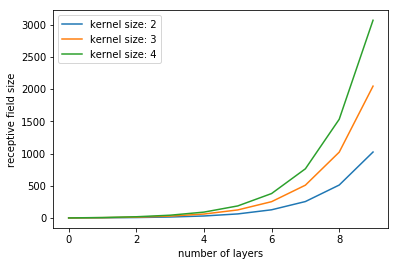

In [10]:
def _receptive_field_size_temporal_conv_net_(kernel_size, n_layers):
    return 1 + 2 * (kernel_size - 1) * (2 ** n_layers - 1)

for k in range(2, 5):
    plt.plot([_receptive_field_size_temporal_conv_net_(kernel_size=k, n_layers=n) for n in range(10)], label=f"kernel size: {k}")
plt.xlabel('number of layers')
plt.ylabel('receptive field size')
plt.legend()

## training

In [11]:
LatentSpaceEncoding = namedtuple('LatentSpaceEncoding', 'mean var')

def get_latent_space(model, X):
    def _encode_(x):
        if hasattr(model, 'encode'):
            # normal model
            return model.encode(x)
        else:
            # only encoder/inference net
            return model(x)
        
    if model.__class__ in [DrosophVAEConv, DrosophVAESkipConv]:
        return LatentSpaceEncoding(*map(lambda x: x.numpy(), _encode_(X)))
    else:
        return LatentSpaceEncoding(*map(lambda x: x.numpy()[back_to_single_time], _encode_(X)))
    
    
def _reshape_and_rescale_(X, scaler=scaler, data_type=run_cfg['data_type']):
    """To be defined in this notebook / function. Basically a larger lambda function
    """
    rescaled = scaler.inverse_transform(X)
    if data_type ==  config.DataType.POS_2D:
        return rescaled.reshape(-1, 15, 2)
    elif data_type ==  config.DataType.ANGLE_3D:
        return rescaled
    else:
        raise ValueError(f"uh, got something odd: {data_type}")
        
def same_experiment_same_fly(exp_0, exp_1):
    keys_0 = experiment_key(obj=exp_0).split('-')
    keys_1 = experiment_key(obj=exp_1).split('-')
    return keys_0[0] == keys_1[0] and keys_0[2] == keys_1[2]

In [12]:
reload(vae_training)
reload(supervised_training)

<module 'drosoph_vae.training.supervised' from '/home/sam/proj/epfl/neural_clustering_vae/drosoph_vae/training/supervised.py'>

In [13]:
from sklearn.metrics import adjusted_mutual_info_score, homogeneity_score, silhouette_score
from drosoph_vae.settings.data import Experiment, experiment_key

def eval_model(training_results, X, X_eval, y, y_frames, run_config, supervised=False):
    #
    # Unsupervised part
    #
    
    model = training_results['model']
    exp_desc = run_config.description(short=False)
    exp_desc_short = run_config.description()
    X_hat_eval = _reshape_and_rescale_(model(X).numpy()[back_to_single_time], data_type=run_config['data_type'])
    epochs = len(training_results['train_reports'])
    
    if supervised:
        exp_desc_short = 'supervised' + exp_desc_short

    
    #
    # Reconstruction plots
    #
    
    if run_config['data_type'] == config.DataType.ANGLE_3D:
        plot_recon_path = plots.plot_reconstruction_comparision_angle_3d(X_eval, X_hat_eval, 
                                                                         epochs=epochs, 
                                                                         selected_columns=selected_columns,
                                                                         run_desc=exp_desc_short)
    else:
        plot_recon_path = plots.plot_reconstruction_comparision_pos_2d(X_eval, X_hat_eval, 
                                                                 epochs=epochs, 
                                                                 run_desc=exp_desc_short)
        
    #
    # Latent plot
    #

    X_latent = get_latent_space(training_results['model'], X)
    X_latent_mean_tsne_proj = TSNE(n_components=2, random_state=42).fit_transform(np.hstack((X_latent.mean, X_latent.var)))

    #cluster_assignments = HDBSCAN(min_cluster_size=8).fit_predict(np.hstack((X_latent.mean, X_latent.var)))
    # average because of the triplet loss (maybe? kinda makes sense... not?)
    cluster_assignments = AgglomerativeClustering(n_clusters=2 * len(list(config.Behavior)), linkage='average')\
        .fit_predict(np.hstack((X_latent.mean, X_latent.var)))
                                                                                      
    plot_latent_path = plots.plot_latent_space(X_latent,
                                         X_latent_mean_tsne_proj,
                                         np.array([y.label.name for _, y in y_frames[back_to_single_time]]),
                                         cluster_assignments,
                                         exp_desc_short,
                                         epochs=len(training_results['train_reports']))
    
    #
    # Videos
    #
    group_videos = list(video.group_video_of_clusters(cluster_assignments,
                                                      y_frames[back_to_single_time],
                                                      exp_desc_short, 
                                                      epochs=epochs))
    
    #nmi = normalized_mutual_information(cluster_assignments, y)
    #pur = purity(cluster_assignments, y)
    silhouette = silhouette_score(np.hstack((X_latent.mean, X_latent.var)), y[:, -1])
    adjusted_mutual_info = adjusted_mutual_info_score(y[:, -1], cluster_assignments)
    homogeneity = homogeneity_score(y[:, -1], cluster_assignments)
    
    #
    # Single video of Hubert, the special fly
    # NOTE that the data is altered here
    #

    hubert = Experiment(**SetupConfig.value('hubert'))
    hubert_idx = np.array([same_experiment_same_fly(l, hubert) for l in y_frames[back_to_single_time][:, 1]])

    exp_descs = np.array([experiment_key(obj=l) for l in y_frames[back_to_single_time][:, 1]])

    X_hat_eval = X_hat_eval[hubert_idx, :]
    cluster_assignments = cluster_assignments[hubert_idx]
    image_id_with_exp = y_frames[back_to_single_time][hubert_idx]
    paths = [video._path_for_image_(image_id, label) for image_id, label in image_id_with_exp]

    labels = [l.label.name for l in y_frames[back_to_single_time][hubert_idx, 1]]
    
    if run_config['data_type'] == config.DataType.POS_2D:
        mean_, std_ = normalisation_factors[experiment_key(obj=hubert)]
        X_hat_eval = (X_hat_eval *std_) + mean_

        X_raw_input = (frame_data.reshape(-1, 15, 2) * std_) + mean_
        X_raw_input = X_raw_input[y_frames[back_to_single_time][:, 0].astype(np.int)]
        X_hat_eval = np.clip(X_hat_eval, np.min(X_raw_input), np.max(X_raw_input)) # some odd errors otherwise

        full_video_path = video.comparision_video_of_reconstruction((X_raw_input, X_hat_eval), 
                                                                    cluster_assignments,
                                                                    image_id_with_exp,
                                                                    labels,
                                                                    n_train_data_points,
                                                                    paths,
                                                                    epochs=epochs,
                                                                    run_desc=exp_desc_short)
    else:
        full_video_path = video.comparision_video_of_reconstruction([],
                                                                    cluster_assignments,
                                                                    image_id_with_exp,
                                                                    labels,
                                                                    n_train_data_points,
                                                                    paths,
                                                                    epochs=epochs,
                                                                    run_desc=exp_desc_short)
        
    

    return {'latent_projection': X_latent_mean_tsne_proj, 
            'cluster_assignments': cluster_assignments,
            'plot_paths': {'reconstruction': plot_recon_path, 'latent': plot_latent_path},
            'video_paths': {'groups': group_videos, 'hubert': full_video_path},
            'scores': {
                'silhouette': silhouette,
                'adjusted_mutual_info': adjusted_mutual_info,
                'homogeneity': homogeneity
            }
           }

In [14]:
X = np.vstack((X_train, X_test))
y = np.vstack((y_train, y_test))
y_frames = np.vstack((frame_labels_train, frame_labels_test))

train_dataset = to_tf_data(X_train, y_train, batch_size=run_cfg['batch_size'])
test_dataset = to_tf_data(X_test, y_test, batch_size=run_cfg['batch_size']) 

if run_cfg['use_time_series']:
    back_to_single_time = np.s_[:, -1, :]
else:
    back_to_single_time = np.s_[:]
    
X_eval = _reshape_and_rescale_(X[back_to_single_time])

In [15]:
from itertools import product

def grid_search(grid_search_params):
    parameters = product(*grid_search_params.values())
    # it's important that it is a generator, tensorflow might complain overwise 
    # too many writers and such, depends heavily on the computer
    cfgs = ((p, config.RunConfig(**dict(zip(grid_search_params.keys(), p)))) for p in parameters)
    
    vae_n_epochs = SetupConfig.value('training', 'vae', 'n_epochs')
    vae_n_epochs_eval = SetupConfig.value('training', 'vae', 'n_epochs_eval')
    supervised_n_epochs = SetupConfig.value('training', 'supervised', 'n_epochs')
    supervised_n_epochs_eval = SetupConfig.value('training', 'supervised', 'n_epochs_eval')
        
    for p, cfg in cfgs:
        #
        # Unsupervised part
        #
        
        # not the best code, but it needs to run... some results are better than none
        try:
            # this allows continuous training with a fixed number of epochs. uuuh yeah.
            # there is however a side-effect problem here. I am running this on a GPU, `init` and `train` need to be called in order.
            # it needs to be init->train, init->train, ... init resets the graph, and I guess this will free up memory
            vae_training_args = vae_training.init(input_shape=X_train.shape[1:], run_config=cfg)
            # model, losses, ...
            vae_training_results = {}
            # paths
            vae_eval_results = []
            for u in range(np.int(vae_n_epochs/ vae_n_epochs_eval)):
                vae_training_results = vae_training.train(**{**vae_training_args, **vae_training_results},
                                                          train_dataset=train_dataset, 
                                                          test_dataset=test_dataset,
                                                          early_stopping=False,
                                                          n_epochs=vae_n_epochs_eval)

                vae_eval_results += [eval_model(vae_training_results, X, X_eval, y, y_frames, cfg)]
                #for n, p in vae_eval_results[-1]['plot_paths'].items():
                #    tf_helpers.tf_write_image(vae_training_args['test_summary_writer'], n, p, vae_training_results['train_reports'].shape[0])

        except Exception:
            print(f"problem with unsupervised {vae_training_args}: {traceback.format_exc()}")
            continue
            
        try:
            base_mdl = vae_training_results['model'].__class__(**vae_training_args['model_config'])
            base_mdl.load_weights(vae_training_args['model_checkpoints_path'])

            vae_training_results['model'] = base_mdl
            vae_best = eval_model(vae_training_results, X, X_eval, y, y_frames, cfg)
        except Exception:
            print(f"problem with loading the model: {traceback.format_exc()}")
            continue
        #
        # Supervised part
        # 
        
        try:
            # the training process saves the model with the min loss.
            
            supervised_training_args = supervised_training.init(model=base_mdl.inference_net, run_config=cfg)
            supervised_training_results = {}
            supervised_eval_results = []
            
            for u in range(np.int(supervised_n_epochs/ supervised_n_epochs_eval)):
                supervised_training_results = supervised_training.train(**{**supervised_training_args, **supervised_training_results},
                                                          train_dataset=train_dataset, 
                                                          test_dataset=test_dataset,
                                                          early_stopping=False,
                                                          n_epochs=supervised_n_epochs_eval)

                base_mdl.inference_net = supervised_training_results['model']
                supervised_training_results['model'] = base_mdl 
                supervised_eval_results += [eval_model(supervised_training_results, X, X_eval, y, y_frames, cfg, supervised=True)]
                supervised_training_results['model'] = base_mdl.inference_net

            
            # it always saves the full model
            base_mdl.load_weights(vae_training_args['model_checkpoints_path'])
            base_mdl.inference_net.load_weights(supervised_training_args['model_checkpoints_path'])
            supervised_training_results['model'] = base_mdl 
            supervised_best = eval_model(supervised_training_results, X, X_eval, y, y_frames, cfg, supervised=True)
        except Exception:
            print(f"problem with supervised {vae_training_args}\n\t{supervised_training_args}\n\t{traceback.format_exc()}")
            continue
        
        # too many figures overwise (duh)
        plt.close('all')
        
        res = {'parameters': p,
               'vae': {'train_reports': vae_training_results['train_reports'], 
                       'test_reports':  vae_training_results['test_reports'],
                       'model_checkpoints_path': vae_training_args['model_checkpoints_path'],
                       'best_model_eval_results': vae_best,
                       'eval_results': vae_eval_results},
               'supervised': {'train_reports': supervised_training_results['train_reports'],
                              'test_reports':  supervised_training_results['test_reports'],
                              'model_checkpoints_path': supervised_training_args['model_checkpoints_path'],
                              'best_model_eval_results': supervised_best,
                              'eval_results': supervised_eval_results}}
        
        yield res

In [16]:
import logging

class NoParsingFilter(logging.Filter):
    def filter(self, record):
        return not ('input image is not divisible' in record.getMessage())

# such a pain in the ass
logger= logging.getLogger('imageio_ffmpeg')
logger.setLevel(logging.INFO)
logger.addFilter(NoParsingFilter())

In [17]:
from datetime import datetime
# Note that the data will be reused -> Don't adapt the data_type here. 
# Either include the data loading into the grid-search or make two runs, one for each DataType

grid_search_params = {
    'model_impl': list(config.ModelType),
    'latent_dim': [2, 4, ],
    'vae_learning_rate': [1e-4, 1e-6],
    'supervised_learning_rate': [1e-5, ],
    'time_series_length': [16, 42],
}

with warnings.catch_warnings():
    warnings.simplefilter(action='ignore', category=FutureWarning)
    started_at = datetime.now().strftime("%Y%m%d-%H%M%S")
    if SetupConfig.runs_on_lab_server():
        grid_search_results = list(grid_search(grid_search_params))
        misc.dump_results(grid_search_results, f"grid_search_only_vae_{started_at}")
    else:
        grid_search_params = {
            'model_impl': [config.ModelType.SKIP_PADD_CONV], # config.ModelType.values(),
            'latent_dim': [2, ]
        }
        grid_search_results = list(grid_search(grid_search_params))
        misc.dump_results(grid_search_results, f"grid_search_only_vae_{started_at}")

Using model: ModelType.SKIP_PADD_CONV


2019-06-15 23:47:38,917 - tensorflow - WARNING - deprecation_wrapper - From /home/sam/proj/epfl/neural_clustering_vae/drosoph_vae/models/drosoph_vae.py:115: The name tf.random_normal is deprecated. Please use tf.random.normal instead.



Epoch: 0000, train/test loss: 1.923	 2.733 took 5.833 sec
Epoch: 0000, train/test loss: 1.000	 1.000 took 1.947 sec


In [19]:
grid_search_results

[{'parameters': (<ModelType.SKIP_PADD_CONV: 2>, 2),
  'vae': {'train_reports': array([[1.92296663, 1.92296663, 0.17722391],
          [1.90406808, 1.90406808, 0.18091286],
          [1.87522392, 1.87522392, 0.18521823],
          [1.86022982, 1.86022982, 0.19059084]]),
   'test_reports': array([[2.73343933, 2.73343933, 0.17722384],
          [2.68942308, 2.68942308, 0.18091247],
          [2.67720544, 2.67720544, 0.1852181 ],
          [2.68128562, 2.68128562, 0.19058998]]),
   'model_checkpoints_path': '/home/sam/proj/epfl/neural_clustering_data/models/SKIP_PADD_CONV-POS_2D-t-16-ld-8-mf-T_20190615-234738/checkpoint',
   'best_model_eval_results': {'latent_projection': array([[  3.309956 , -37.229736 ],
           [ -2.206424 ,  51.12841  ],
           [ -5.510165 , -24.075493 ],
           ...,
           [  7.8207755,  46.002445 ],
           [  3.5806134, -45.49971  ],
           [ 23.580116 , -23.049122 ]], dtype=float32),
    'cluster_assignments': array([ 9,  1,  9, ...,  1, 12, 

In [18]:
stop

NameError: name 'stop' is not defined

In [ ]:
reload(tf_helpers)
reload(vae_training)
reload(video)

In [ ]:
#if not SetupConfig.runs_on_lab_server():
#    reload(vae_training)
#    epochs = 14
#    eval_steps = 7
#    run_cfg['latent_dim'] = 6
#    vae_training_args = vae_training.init(input_shape=X_train.shape[1:], run_config=run_cfg)
#    vae_training_results = {}
#    eval_results = []
#    for u in range(np.int(epochs / eval_steps)):
#        vae_training_results = vae_training.train(**{**vae_training_args, **vae_training_results},
#                                                  train_dataset=train_dataset, 
#                                                  test_dataset=test_dataset,
#                                                  early_stopping=False,
#                                                  n_epochs=eval_steps)
#
#        eval_results += [eval_model(vae_training_results, X, X_eval, y, y_frames, run_cfg)]
#
#    eval_results += [eval_model(vae_training_results, X, X_eval, y, y_frames, run_cfg)]

In [ ]:
reload(supervised_training)

cfg = RunConfig(model_impl=config.ModelType.SKIP_PADD_CONV, latent_dim=1)
vae_training_args = vae_training.init(input_shape=X_train.shape[1:], run_config=cfg)
vae_training_results = {}
vae_eval_results = []
epochs = 14
eval_steps = 7

try:
    for u in range(np.int(epochs / eval_steps)):
            vae_training_results = vae_training.train(**{**vae_training_args, **vae_training_results},
                                                      train_dataset=train_dataset, 
                                                      test_dataset=test_dataset,
                                                      early_stopping=False,
                                                      n_epochs=eval_steps)

            vae_eval_results += [eval_model(vae_training_results, X, X_eval, y, y_frames, cfg)]
        #for n, p in vae_eval_results[-1]['plot_paths'].items():
        #    tf_helpers.tf_write_image(vae_training_args['test_summary_writer'], n, p, vae_training_results['train_reports'].shape[0])

    vae_eval_results += [eval_model(vae_training_results, X, X_eval, y, y_frames, cfg)]
except Exception:
    print(f"problem with {vae_training_args}: {traceback.format_exc()}")


# the training process saves the model with the min loss.
base_mdl = vae_training_results['model'].__class__(**vae_training_args['model_config'])
base_mdl.load_weights(vae_training_args['model_checkpoints_path'])

supervised_training_args = supervised_training.init(model=base_mdl.inference_net, run_config=cfg)
supervised_training_results = {}
supervised_eval_results = []

for u in range(np.int(epochs / eval_steps)):
    supervised_training_results = supervised_training.train(**{**supervised_training_args, **supervised_training_results},
                                              train_dataset=train_dataset, 
                                              test_dataset=test_dataset,
                                              early_stopping=False,
                                              n_epochs=eval_steps)

    base_mdl.inference_net = supervised_training_results['model']
    supervised_training_results['model'] = base_mdl 
    supervised_eval_results += [eval_model(supervised_training_results, X, X_eval, y, y_frames, cfg)]
    supervised_training_results['model'] = base_mdl.inference_net

base_mdl.inference_net = supervised_training_results['model']
supervised_training_results['model'] = base_mdl 
supervised_eval_results += [eval_model(supervised_training_results, X, X_eval, y, y_frames, cfg)]
supervised_training_results['model'] = base_mdl.inference_net

In [ ]:
base_mdl.inference_net.layers[1].summary()

In [ ]:
X[back_to_single_time].shape

In [ ]:
supervised_training_args['model'](X)

In [ ]:
X.shape

In [ ]:
get_latent_space(supervised_training_results['model'], X)
#     17         return LatentSpaceEncoding(*map(lambda x: x.numpy(), model.encode(X)))
#     18     else:
#---> 19         return LatentSpaceEncoding(*map(lambda x: x.numpy()[back_to_single_time], model.encode(X)))

In [ ]:
a = tf.zeros((128, 16, 4))
b = tf.zeros((128, 16, 4))

In [ ]:
tf.concat((a, b), axis=-1).shape

In [ ]:
eval_results

In [ ]:
vae_training_results['test_reports'][:, 0]

In [ ]:
vae_training

In [ ]:
eval_model(vae_training_results, X, X_eval, y, y_frames, run_cfg)

In [ ]:
from drosoph_vae.settings.data import Experiment, experiment_key
from PIL import Image

In [ ]:
base_mdl = vae_training_results['model'].__class__(latent_dim=run_cfg['latent_dim'], 
                                                   input_shape=X_train.shape[1:],
                                                   batch_size=run_cfg['batch_size'])
base_mdl.load_weights(vae_training_args['model_checkpoints_path'])

X_hat = base_mdl(X).numpy()[back_to_single_time]
X_hat = _reshape_and_rescale_(X_hat, data_type=run_cfg['data_type'])

cluster_assignments = AgglomerativeClustering(n_clusters=2 * len(list(config.Behavior)), linkage='average')\
        .fit_predict(X_encoded)

hubert = Experiment(**SetupConfig.value('hubert'))
hubert_idx = np.array([same_experiment_same_fly(l, hubert) for l in y_frames[back_to_single_time][:, 1]])

exp_descs = np.array([experiment_key(obj=l) for l in y_frames[back_to_single_time][:, 1]])

X_hat = X_hat[hubert_idx, :]
cluster_assignments = cluster_assignments[hubert_idx]
image_id_with_exp = y_frames[back_to_single_time][hubert_idx]
paths = [video._path_for_image_(image_id, label) for image_id, label in image_id_with_exp]

labels = [l.label.name for l in y_frames[back_to_single_time][hubert_idx, 1]]
mean_, std_ = normalisation_factors[experiment_key(obj=hubert)]
X_hat = (X_hat *std_) + mean_

_t = frame_data.reshape(-1, 15, 2)
X_raw_input = np.vstack((_t[run_cfg['time_series_length'] - 1:n_train_data_points], _t[n_train_data_points + run_cfg['time_series_length'] -1:]))

X_raw_input = (X_raw_input * std_) + mean_
X_raw_input = X_raw_input[y_frames[back_to_single_time][:, 0].astype(np.int)][hubert_idx]
X_hat = np.clip(X_hat, np.min(X_raw_input), np.max(X_raw_input)) # some odd errors otherwise

comparision_video_of_reconstruction((X_raw_input, X_hat), cluster_assignments, image_id_with_exp, labels, n_train_data_points, paths, run_desc=run_cfg.description())

In [ ]:
import cv2

In [ ]:
display_video('./tryout.mp4')

In [ ]:
X_encoded = np.hstack([t.numpy() for t in base_mdl.encode(X)])

In [ ]:
SetupConfig.value('fly_image_template')

In [ ]:
X_eval.shape

In [ ]:
normalisation_factors.keys()

In [ ]:
stop

# evaluation

In [ ]:
#if run_cfg['data_type'] == config.DataType.POS_2D:
#    fig = plots.plot_comparing_joint_position_with_reconstructed(X_eval,
#                                                                 X_hat_eval,
#                                                                 X_gen_eval,
#                                                                 validation_cut_off=n_train_data_points,
#                                                                 exp_desc=exp_desc_short);
#else:
#    # ncols is an ugly hack... it works on the basis that we have three working angles for each leg
#    if run_cfg['use_single_fly']:
#        start = 0
#        end = len(X_eval)
#    else:
#        start = 100
#        end = 1000
#    xticks = np.arange(start, end) / SetupConfig.value('frames_per_second') / 60.
#    if run_cfg['debug']:
#        _input_data = X[:, :, 0]
#        _recon = model(X, apply_sigmoid=False).numpy()[:, :, 0]
#        fig, axs = plt.subplots(nrows=_input_data.shape[-1], ncols=1, figsize=(20, 30), sharex=True, sharey=True)
#        for i in range(_input_data.shape[-1]):
#            _idx_ = np.s_[start:end, i]
#            axs[i].plot(xticks, _input_data[_idx_], label='input')
#            axs[i].plot(xticks, _recon[_idx_], label='reconstructed')
#    else:
#        fig, axs = plt.subplots(nrows=X_eval.shape[1], ncols=1, figsize=(20, 30), sharex=True, sharey=True)
#        for i, cn in enumerate(SD.get_3d_columns_names(selected_cols)):
#            _idx_ = np.s_[start:end, i]
#            axs[i].plot(xticks, X_eval[_idx_], label='input')
#            axs[i].plot(xticks, reconstructed_data[_idx_], label='reconstructed')
#
#            axs[i].set_title(cn)
#
#    axs[-1].set_xlabel('time [min]')
#    axs[0].legend(loc='upper left')
#    
#    #plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
#    plt.suptitle(f"Comparision of selection of data\n({exp_desc})")
#    
#    plt.tight_layout()
#    plt.subplots_adjust(top=0.94)
#    plt.savefig(f"./figures/{exp_desc_short}_input_gen_recon_comparision.png")

# Latent space

In [ ]:
#plot_latent_space(X_latent, X_latent_mean_tsne_proj, y, run_cfg, epochs=len(vae_training_results['train_reports']))

In [ ]:
#from matplotlib.collections import LineCollection
#
#def plot_debug(input_data, cluster_assignments, cluster_colors=None):
#    _clusters = np.unique(cluster_assignments)
#    _colors = sns.color_palette(n_colors=len(_clusters))
#    if cluster_colors is None:
#        cluster_colors = dict(zip(_clusters, _colors))
#        
#    lines, colors = zip(*[([(x, input_data[x, 0]) for x in segment], cluster_colors[cluster_id])
#                           for cluster_id, segments in video.group_by_cluster(cluster_assignments).items() 
#                           for segment in segments])
#
#
#    
#    fig, ax = plt.subplots(figsize=(10, 8))
#    coll = LineCollection(lines, colors=colors)
#    #coll.set_array(np.random.random(xy.shape[0]))
#
#    ax.add_collection(coll)
#    ax.autoscale_view()
#
#    plt.title('Input data and cluster assigment using debug data');
#    
#if run_cfg['debug']:
#    plot_debug(input_data, cluster_assignments)

In [ ]:
# TODO
# use this to add a different shape to the scatter plot
# frames_idx_with_labels[:len(frames_of_interest)][frames_of_interest][run_config['time_series_length'] - 1:]['label'].apply(lambda x: x.value)

# videos

In [ ]:
#cluster_assignments = eval_results[-1]['cluster_assignments']
#
#group_videos = list(video.group_video_of_clusters(cluster_assignments, y_frames[back_to_single_time], run_cfg))

In [ ]:
stop

In [ ]:

#new_im.save('test.jpg')

In [ ]:
def reverse_pos_pipeline(x, normalisation_factors):
    """TODO This is again pretty shitty... ultra hidden global variable"""
    return x + normalisation_factors[:x.shape[-1]]

def video_prep_raw_data(data):
    if run_config['use_time_series']:
        return reverse_pos_pipeline(scaler.inverse_transform(data[:, -1, :]).reshape(-1, 15, 2))
    else:
        return reverse_pos_pipeline(scaler.inverse_transform(data.reshape(-1, 30)).reshape(-1, 15, 2))
    
def video_prep_recon_data(input_data):
    return reverse_pos_pipeline(scaler.inverse_transform(model(input_data).numpy()).reshape(-1, 15, 2))

In [ ]:
if run_config['data_type'] == _DATA_TYPE_2D_POS_:
    _positional_data_ = [reverse_pos_pipeline(input_data, normalisation_factors=normalisation_factors), 
                         reverse_pos_pipeline(reconstructed_data, normalisation_factors=normalisation_factors)]
else:
    raise NotImplementedError('give me a break')
    
p = video.comparision_video_of_reconstruction(_positional_data_,
                                              images_paths_for_experiments=images_paths_for_experiments, 
                                              n_train=len(data_train),
                                              cluster_assignments=cluster_assignments,
                                              as_frames=False,
                                              exp_desc=exp_desc_short)

display_video(p)

In [ ]:
# Super ugly... but necessary...
# first there is the time offset due to the slicing
# then there is the concatenation of the data...

angle_data_pos_to_frame = []

for exp_key, data in angle_data_raw: 
    _exp = SD._experiment_from_key_(exp_key)
    
    if len(angle_data_pos_to_frame) == 0:
        _idx = np.arange(data.shape[0])[run_config['time_series_length'] - 1:]
    else:
        _idx = np.arange(data.shape[0])# + len(angle_data_pos_to_frame)
        
    angle_data_pos_to_frame += [(_exp, d) for d in _idx]

In [ ]:
        images_paths_for_experiments = settings.data.EXPERIMENTS.map(lambda x: (x, config.positional_data(x)))\
                                               .flat_map(lambda x: [(x[0], config.get_path_for_image(x[0], i)) for i in range(x[1].shape[1])])\
                                               .to_list()

In [ ]:

    frames_idx_with_labels = preprocessing.get_frames_with_idx_and_labels(settings.data.LABELLED_DATA)
    frames_of_interest = ~frames_idx_with_labels['label'].isin([settings.data._BehaviorLabel_.REST])

In [ ]:
images_paths_for_experiments = [(exp, config.get_path_for_image(exp, i)) for exp, i in angle_data_pos_to_frame]

In [ ]:
images_paths_for_experiments[-10:]

In [ ]:
reload(video)
from collections import OrderedDict
_N_CLUSTER_TO_VIZ_ = 10
_t = [(misc.flatten(sequences), cluster_id) for cluster_id, sequences in video.group_by_cluster(cluster_assignments).items()]
_t = sorted(_t, key=lambda x: len(x[0]), reverse=True)

cluster_colors = sns.color_palette(n_colors=len(np.unique(cluster_assignments)))

cluster_vids = OrderedDict((p[1], video.comparision_video_of_reconstruction(input_data,
                                                                            cluster_assignments=cluster_assignments,
                                                                            images_paths_for_experiments=images_paths_for_experiments,
                                                                            n_train=data_train.shape[0],
                                                                            cluster_colors=cluster_colors,
                                                                            cluster_id_to_visualize=p[1], 
                                                                            exp_desc=exp_desc_short,
                                                                            is_2d=False))
                    for p in _t[:_N_CLUSTER_TO_VIZ_])

print('cluster_vids: ', cluster_vids.keys())

In [ ]:
! cat ./drosoph_vae/helpers/video.py

In [ ]:
from collections import OrderedDict
_N_CLUSTER_TO_VIZ_ = 10
_t = [(misc.flatten(sequences), cluster_id) for cluster_id, sequences in video.group_by_cluster(cluster_assignments).items()]
_t = sorted(_t, key=lambda x: len(x[0]), reverse=True)

cluster_colors = sns.color_palette(n_colors=len(np.unique(cluster_assignments)))

cluster_vids = OrderedDict((p[1], video.comparision_video_of_reconstruction(_positional_data_,
                                                                      cluster_assignments=cluster_assignments,
                                                                      images_paths_for_experiments=images_paths_for_experiments,
                                                                      n_train=data_train.shape[0],
                                                                      cluster_colors=cluster_colors,
                                                                      cluster_id_to_visualize=p[1], exp_desc=exp_desc_short))
                    for p in _t[:_N_CLUSTER_TO_VIZ_])

print('cluster_vids: ', cluster_vids.keys())

In [ ]:
#c_idx = 0
c_idx += 1
display_video(list(cluster_vids.values())[c_idx])

In [ ]:
c_idx = 0
#c_idx += 1
display_video(list(cluster_vids.values())[c_idx])

In [ ]:
images_paths_for_experiments

In [ ]:
len(np.where(cluster_assignments == 11)[0])

In [ ]:
np.array(images_paths_for_experiments)

In [ ]:
for fs, c in _t:
    print(f"cluster {c} has {len(fs)} elements")

In [ ]:
reload(video)

_t = [(misc.flatten(sequences), cluster_id) for cluster_id, sequences in video.group_by_cluster(cluster_assignments).items()]
_t = sorted(_t, key=lambda x: len(x[0]), reverse=True)
p = video.video_angle(cluster_assignments, images_paths_for_experiments, cluster_id_to_visualize=_t[3][1], exp_desc=exp_desc_short)

In [ ]:
display_video(p)

In [ ]:
stop

# Convolution Clarification

Below are the results shown for a Conv1d for all padding options:

- valid: only convolutions where the kernel fits inside the input are comptued
- causal: input is shifted such that the kernel can only see itself and backwards in time
- same: input is padded such that the convolution can also be applied to the border cases

kernel sizes of 2 & 3, and dilation rates for 1 to 3.

The result is that a valid convolution of kernel size 2 with a dilation factor of 1 compresses the input in a for us good way.
The data goes from `[batch_size, n_time_steps, n_channels]` to `[batch_size, n_time_steps - 1, n_filters]` 
and crops the first time step only. Thus building features by only looking backwards in time,
dropping the first-time step. Thus features are build over time and space.

In [ ]:
example_data = np.zeros((1, 10, 5), dtype=np.float32)

for row in range(example_data.shape[1]):
    example_data[:, row, :] = row
    
example_data

In [ ]:
def conv_clarification_kernel(kernel_size):
    conv1d_kernel_no_time = np.zeros((kernel_size, example_data.shape[-1], 1), dtype=np.float32)
    conv1d_kernel_no_time[0, :, :] = .5
    conv1d_kernel_no_time[1, :, :] = 1.
    
    if kernel_size == 3:
        conv1d_kernel_no_time[2, :, :] = 0.1
    
    return conv1d_kernel_no_time


for kernel_size in range(2, 4):
    print(f"data\n{example_data}")
    print(f"kernel\n{conv_clarification_kernel(kernel_size)}")
    for padding in ['valid', 'causal', 'same']:
        for dilation in range(1, 4):
            example_conv1d = tfkl.Conv1D(filters=1, 
                                         kernel_size=kernel_size,
                                         use_bias=False, 
                                         padding=padding,
                                         dilation_rate=dilation,
                                         kernel_initializer=tf.constant_initializer(conv_clarification_kernel(kernel_size)))

            conv_res = example_conv1d(example_data).numpy()
            print(f"padding: {padding}, dilation_rate: {dilation}, kernel_size: {kernel_size}, output shape: {conv_res.shape}\n{conv_res}")

In [ ]:
def conv_clarification_kernel(kernel_size):
    conv1d_kernel_no_time = np.zeros((kernel_size, example_data.shape[-1], example_conv1d_n_filters), dtype=np.float32)
    conv1d_kernel_no_time[0, :, :] = .5
    conv1d_kernel_no_time[1, :, :] = 1.
    
    if kernel_size == 3:
        conv1d_kernel_no_time[2, :, :] = 0.1
    
    return conv1d_kernel_no_time

kernel_size = 2
padding = 'valid'
dilation_rate = 1
example_conv1d_n_filters = 2

print(f"data\n{example_data}")
print(f"kernel\n{conv_clarification_kernel(kernel_size)}")
example_conv1d = tfkl.Conv1D(filters=example_conv1d_n_filters, 
                             kernel_size=kernel_size,
                             use_bias=False, 
                             padding=padding,
                             dilation_rate=dilation_rate,
                             kernel_initializer=tf.constant_initializer(conv_clarification_kernel(kernel_size)))

example_max_pooling_layer = tfkl.MaxPool1D()
example_dense = tfkl.Dense(2, use_bias=False, kernel_initializer='ones')

conv_res = example_conv1d(example_data[:,:2,:]).numpy()
#max_pool_res = example_max_pooling_layer(conv_res)
#dense_res = example_dense(max_pool_res)
print(f"padding: {padding}, dilation_rate: {dilation_rate}, kernel_size: {kernel_size}, output shape: {conv_res.shape}")
print('conv\n', conv_res)
#print('max pool\n', max_pool_res.numpy())
#print('dense\n', dense_res.numpy())

In [ ]:
conv_res

In [ ]:
class Conv1D_Transpose(tfkl.Layer):
    def __init__(self, n_filters, kernel_size, batch_size):
        super(Conv1D_Transpose, self).__init__()        
        self.n_filters = n_filters
        self.batch_size = batch_size
        self.conv2d_transpose = tfkl.Conv2DTranspose(filters=n_filters, kernel_size=kernel_size, strides=2, padding='valid', kernel_initializer='ones')
        
    def call(self, inputs):
        x = tf.reshape(inputs, [self.batch_size, 1, *inputs.shape[1:]])
        print(x.shape)
        x = self.conv2d_transpose(x)
        #x = tf.reshape(x, [self.batch_size, -1, self.n_filters])
        
        return x

example_deconv1d = Conv1D_Transpose(n_filters=2, kernel_size=2, batch_size=1)
example_deconv1d(conv_res)

In [ ]:
_ted = example_deconv1d(conv_res)
tf.reshape(_ted, _ted.shape[:-1])

In [ ]:
UpsamplingConv(2)(conv_res)

In [ ]:
tfkl.UpSampling1D(3)(conv_res)

In [ ]:
class UpsamplingConv(tfkl.Layer):
    def __init__(self, n_filters, kernel_size=2):
        super(UpsamplingConv, self).__init__()
        
        self.n_filters = n_filters
        self.kernel_size = kernel_size
    
    def call(self, x): 
        x = tfkl.UpSampling1D(3)(x) # upscale with 3 so that we can again apply `valid` padding and "reverse" the encoder
        print(x.shape)
        # TODO maybe add some fancy flipping of the input
        x = tfkl.Conv1D(self.n_filters, self.kernel_size, padding='valid')(x)
        
        return x

In [ ]:
conv_res.shape

In [ ]:
conv_res

In [ ]:
example_deconv = tfkl.Conv2DTranspose(1, 2, kernel_initializer='ones')
example_deconv(conv_res.reshape(-1, 1, *conv_res.shape[1:])).numpy().reshape(-1, *conv_res.shape[1:])

In [ ]:
conv_res

In [ ]:
conv_res.shape

In [ ]:
conv_res

In [ ]:
tf.rank(conv_res)

In [ ]:
paddings = [[r, 0] for r in range(3)]
paddings

In [ ]:
tf.pad(conv_res, [[0, 0], [0, 1], [0, 0]])

In [ ]:
tfc.nn.conv1d_transpose(input=conv_res, filters=np.ones((2, 2, 2), dtype=np.float32), output_shape=[1, 2, 2], strides=1, padding='VALID')

In [ ]:
_pdc1dt = PaddedConv1dTransposed(n_filters=2)
print(conv_res.shape)
resc1 = _pdc1dt(conv_res)
print(resc1.shape)
resc1.numpy()

In [ ]:
_pdc1dt(_pdc1dt(resc1))

In [ ]:
#_t_layer_sizes_generative=[4,6,8,10,12,14,16,18]
#_t_layer_sizes_generative=[1] * 6
#_t_upsampling_size = [4] * 6 #, 2, 2]
#_t_strides = [2] * 6
##_t_padding = ['valid', 'valid', 'same']
##_t_layer_sizes_generative=[4, 8, 16]
#_latent_dim = 2
#_t_generative_net = tf.keras.Sequential([tfkl.InputLayer(input_shape=(_latent_dim,)),
#                                           tfkl.Lambda(lambda x: tf.reshape(x, [1000, 1, _latent_dim])),
#                                           *[TemporalUpsamplingConv(conv_n_filters=fs, 
#                                                                    upsampling_size=us,
#                                                                    conv_strides=s,
#                                                                    conv_padding='valid',
#                                                                    name=f"gen_conv_{i}") for i, (fs, us, s) 
#                                             in enumerate(zip(_t_layer_sizes_generative,
#                                                              _t_upsampling_size,
#                                                              _t_strides,
#                                                             ))]],
#                                          name='generative_net')
#
#_t_generative_net.summary()